In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
%cd "/content/gdrive/MyDrive/Grupo 8 - MIA2024/SEGUNDO CICLO/Redes Neuronales y Aprendizaje Profundo/Tarea1/"

/content/gdrive/MyDrive/Grupo 8 - MIA2024/SEGUNDO CICLO/Redes Neuronales y Aprendizaje Profundo/Tarea1


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim.lr_scheduler as lr_scheduler
import os

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Definir las transformaciones para entrenamiento, validación y test
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),  # Redimensionar aleatoriamente y recortar
    transforms.RandomHorizontalFlip(),  # Flip horizontal aleatorio
    transforms.ToTensor(),  # Convertir a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizar con los valores de ImageNet
])

transform_test = transforms.Compose([
    transforms.Resize(256),  # Redimensionar la imagen a 256px por el lado más largo
    transforms.CenterCrop(224),  # Recortar a 224x224
    transforms.ToTensor(),  # Convertir a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizar con los valores de ImageNet
])

In [ ]:
class Bottleneck(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)  # 1x1 convolution
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)  # 3x3 convolution
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * 4, kernel_size=1, bias=False)  # 1x1 convolution to increase channels
        self.bn3 = nn.BatchNorm2d(out_channels * 4)
        self.relu = nn.ReLU(inplace=True)

        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [ ]:
class ResNet50(nn.Module):
    def __init__(self, block, layers, num_classes=3):
        super(ResNet50, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)  # First layer with large 7x7 kernel
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * 4:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * 4, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * 4),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * 4  # Update in_channels to match the output of the block

        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        x = self.fc(x)

        return x

In [ ]:
def ResNet50_model(num_classes=3):
    return ResNet50(Bottleneck, [3, 4, 6, 3], num_classes)

In [ ]:
if __name__ == '__main__':  # Fix for Windows multiprocessing issue
     # Directorios de datos
    train_dir = './data/train'
    val_dir = './data/validation'
    test_dir = './data/test'

    # Cargar datasets desde carpetas
    train_dataset = datasets.ImageFolder(train_dir, transform=transform_train)
    val_dataset = datasets.ImageFolder(val_dir, transform=transform_test)
    test_dataset = datasets.ImageFolder(test_dir, transform=transform_test)

    # DataLoaders para entrenamiento, validación y prueba
    train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True, num_workers=4)
    val_loader = DataLoader(dataset=val_dataset, batch_size=128, shuffle=False, num_workers=4)
    test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False, num_workers=4)

    # Inicializar el modelo, función de pérdida y optimizador
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ResNet50_model(num_classes=3).to(device)  # Asegúrate de pasar el número correcto de clases
    criterion = nn.CrossEntropyLoss()

    # Usar el optimizador AdamW y el scheduler de tasa de aprendizaje (CosineAnnealing)
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

    num_epochs = 10  # Número de épocas
    for epoch in range(num_epochs):
        model.train()  # Configurar el modelo en modo de entrenamiento
        running_loss = 0.0
        correct = 0
        total = 0

        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  # Reiniciar los gradientes

            outputs = model(inputs)  # Paso adelante
            loss = criterion(outputs, labels)  # Calcular la pérdida

            loss.backward()  # Retropropagación
            optimizer.step()  # Actualización de los parámetros

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        # Actualizar el scheduler
        scheduler.step()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100*correct/total:.2f}%')

        # Validación
        model.eval()  # Cambiar a modo de evaluación
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                val_outputs = model(val_inputs)
                _, val_predicted = val_outputs.max(1)
                val_total += val_labels.size(0)
                val_correct += val_predicted.eq(val_labels).sum().item()

        print(f'Validation Accuracy: {100 * val_correct / val_total:.2f}%')

    # Evaluación final en el conjunto de prueba
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for test_inputs, test_labels in test_loader:
            test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
            outputs = model(test_inputs)
            _, predicted = torch.max(outputs, 1)
            total += test_labels.size(0)
            correct += (predicted == test_labels).sum().item()

    print(f'Accuracy on test set: {100 * correct / total:.2f}%')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [1/10], Loss: 0.3610, Accuracy: 86.28%
Validation Accuracy: 81.07%
Epoch [2/10], Loss: 0.2721, Accuracy: 89.44%
Validation Accuracy: 89.51%
Epoch [3/10], Loss: 0.2294, Accuracy: 90.74%
Validation Accuracy: 90.89%
Epoch [4/10], Loss: 0.1994, Accuracy: 91.89%
Validation Accuracy: 90.93%
Epoch [5/10], Loss: 0.2032, Accuracy: 91.87%
Validation Accuracy: 95.69%
Epoch [6/10], Loss: 0.1891, Accuracy: 92.97%
Validation Accuracy: 88.40%
Epoch [7/10], Loss: 0.2003, Accuracy: 92.85%
Validation Accuracy: 95.42%
Epoch [8/10], Loss: 0.1381, Accuracy: 94.67%
Validation Accuracy: 96.89%
Epoch [9/10], Loss: 0.1226, Accuracy: 95.29%
Validation Accuracy: 97.42%
Epoch [10/10], Loss: 0.1182, Accuracy: 95.98%
Validation Accuracy: 98.00%
Accuracy on test set: 98.00%


In [ ]:
torch.save(model, "./Notebooks/output/Resnet50.pt")

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

model.eval()

def predict_image(image_path, model):
    # Cargar la imagen desde el archivo
    image = Image.open(image_path)

    # Mostrar la imagen para visualización
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    # Preprocesar la imagen
    image_tensor = transform_test(image).unsqueeze(0)  # Añadir una dimensión para batch

    # Mover la imagen a GPU si está disponible
    image_tensor = image_tensor.to(device)

    # Hacer la predicción
    with torch.no_grad():  # No calcular gradientes en inferencia
        output = model(image_tensor)
        probabilities = torch.softmax(output, dim=1)  # Obtener probabilidades
        confidence, predicted_class = torch.max(probabilities, 1)  # Obtener la clase predicha y su confianza

    return predicted_class.item(), confidence.item(), probabilities

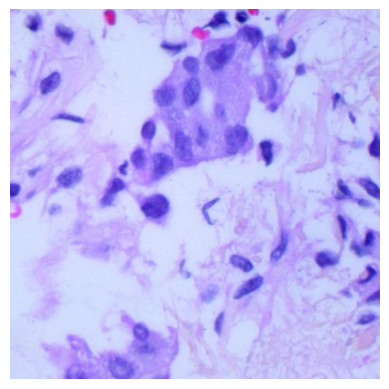

Predicción: adenocarcinoma con 98.48% confidence


In [ ]:
image_path = './data/test/adenocarcinoma/0096.jpg'
predicted_class, confidence, probabilities = predict_image(image_path, model)

classes = ['adenocarcinoma', 'benign', 'squamous_cell_carcinoma']

print(f'Predicción: {classes[predicted_class]} con {confidence*100:.2f}% confidence')

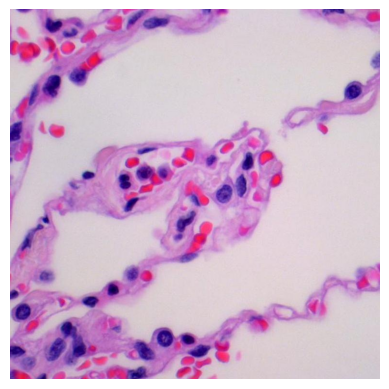

Predicción: benign con 100.00% confidence


In [ ]:
image_path = './data/test/benign/0087.jpg'
predicted_class, confidence, probabilities = predict_image(image_path, model)

print(f'Predicción: {classes[predicted_class]} con {confidence*100:.2f}% confidence')

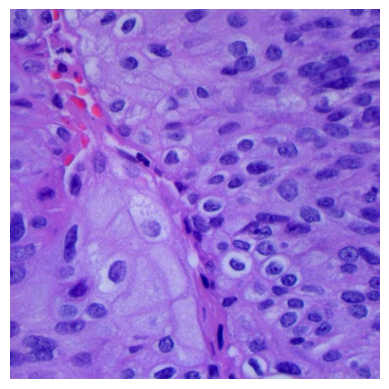

Predicción: squamous_cell_carcinoma con 98.92% confidence


In [ ]:
image_path = './data/test/squamous_cell_carcinoma/0122.jpg'
predicted_class, confidence, probabilities = predict_image(image_path, model)

print(f'Predicción: {classes[predicted_class]} con {confidence*100:.2f}% confidence')